In [1]:
import torch, os, librosa, h5py
from torch.utils.data import Dataset 
import torch.nn as nn
from ssip.spect_model import GradLogPEstimator2d
from ssip.diffusion_base import SDEDiffusion
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import resample
from sklearn.decomposition import PCA

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/ahmed348/SSIP/ssip/diffusion_base.py:998: SyntaxWarning: invalid escape sequence '\i'
  """Stochastic Differential Equation (SDE) based diffusion model, as proposed in


### **Likelihood model and preparation of Finkerlab data**

In [2]:
def whisper_log_mel_spectrogram_numpy(audio: np.ndarray, 
                                      sample_rate: int = 16000, 
                                      n_mels: int = 80) -> np.ndarray:
    # Convert to mono if multi-channel
    if audio.ndim == 2:
        audio = audio.mean(axis=0)  # average across channels
    elif audio.ndim != 1:
        raise ValueError(f"Audio array must be 1D or 2D, got {audio.ndim}D")
    # Whisper parameters
    n_fft = 400
    hop_length = 160
    win_length = 400
    f_min = 0
    f_max = 8000
    # Compute STFT
    stft = librosa.stft(audio, 
                        n_fft=n_fft, 
                        hop_length=hop_length, 
                        win_length=win_length,
                        window='hann',
                        center=True,
                        pad_mode='reflect')
    # Compute magnitude spectrogram
    magnitude = np.abs(stft) ** 2  # power spectrogram
    # Create Mel filterbank
    mel_basis = librosa.filters.mel(sr=sample_rate,
                                    n_fft=n_fft,
                                    n_mels=n_mels,
                                    fmin=f_min,
                                    fmax=f_max,
                                    htk=True)  # Use HTK formula like Whisper
    
    # Apply Mel filterbank
    mel = np.dot(mel_basis, magnitude)
    # Log compression (base 10 like Whisper)
    log_mel = np.log10(np.clip(mel, a_min=1e-10, a_max=None))
    return log_mel

In [3]:
metadata =  h5py.File('/home/ahmed348/finkerlab_data/HB02.h5')
ecog = metadata['ecog_alldataset']          # shape (N_samples, n_channels)
speech = metadata['wave_re_alldataset']     # shape (N_samples,) or (N_samples, nch)
start_idx = metadata['start_ind_re_valid_alldataset']
end_idx = metadata['end_ind_re_valid_alldataset']

fs_ecog = 125
fs_speech = 16000
target_fs = 100               # 100 Hz target sampling rate
hop_length = int(0.01 * fs_speech)   # 0.01 sec → 160 samples
win_length = int(0.025 * fs_speech)  # 25 ms window
n_fft = 1024
n_mels = 80 
target_frames = 100           # exactly 1 second at 100 Hz
ecog_trials = []; mel_trials = []; durations = []

for i in range(len(start_idx)):
    s_e = start_idx[i]
    e_e = end_idx[i]
    ecog_seg = ecog[s_e:e_e]      # (T_ecog, n_channels)
    start_t = s_e / fs_ecog
    end_t   = e_e / fs_ecog
    s_sp = int(start_t * fs_speech)
    e_sp = int(end_t   * fs_speech)

    speech_seg = np.squeeze(speech[s_sp:e_sp])
    # print(speech_seg.shape)
    # skip tiny segments
    if len(speech_seg) < hop_length:
        continue
    mel = whisper_log_mel_spectrogram_numpy(speech_seg, fs_speech)
    # Resample ECoG to target_fs
    T_target = int(np.round((end_t - start_t) * target_fs))
    if T_target <= 0:
        continue
    # Guard in case ecog_seg is 1D -> make it Nx1
    if ecog_seg.ndim == 1:
        ecog_seg = ecog_seg[:, None]
    ecog_resampled = resample(ecog_seg, T_target, axis=0)  # (T_target, n_channels)

    # ----- Clip or pad MEL to (n_mels, target_frames) -----
    T_mel = mel.shape[1]
    if T_mel >= target_frames:
        mel_fixed = mel[:, :target_frames].astype(np.float32)
    else:
        mel_fixed = np.zeros((n_mels, target_frames), dtype=np.float32)
        mel_fixed[:, :T_mel] = mel

    # ----- Clip or pad ECoG to (target_frames, n_channels) -----
    T_e = ecog_resampled.shape[0]
    n_channels = ecog_resampled.shape[1]
    if T_e >= target_frames:
        ecog_fixed = ecog_resampled[:target_frames, :].astype(np.float32)
    else:
        ecog_fixed = np.zeros((target_frames, n_channels), dtype=np.float32)
        ecog_fixed[:T_e, :] = ecog_resampled
    ecog_trials.append(ecog_fixed)        # (target_frames, n_channels)
    mel_trials.append(mel_fixed)          # (n_mels, target_frames)
    durations.append(end_t - start_t)
# Convert to arrays
ecog_data = np.stack(ecog_trials, axis=0)   # (num_trials, target_frames, n_channels)
mel_data = np.stack(mel_trials, axis=0)     # (num_trials, n_mels, target_frames)
durations = np.array(durations)
print("ECoG trials :", ecog_data.shape)
print("MEL trials  :", mel_data.shape)
# Fixed indices for validation set (first 20%)
n_samples = len(mel_data)
n_val = int(n_samples * 0.2)
# Use first n_val samples for validation
mel_val = mel_data[:n_val]
ecog_val = ecog_data[:n_val]
mel_train = mel_data[n_val:]
ecog_train = ecog_data[n_val:]


ECoG trials : (372, 100, 225)
MEL trials  : (372, 80, 100)


**Do PCA**

In [4]:
ecog_train_flat = ecog_train.reshape(-1, ecog_train.shape[-1])
pca = PCA(n_components=20)
ecog_train_pca_flat = pca.fit_transform(ecog_train_flat)
# Transform val using the trained PCA
ecog_val_flat = ecog_val.reshape(-1, ecog_val.shape[-1])
ecog_val_pca_flat = pca.transform(ecog_val_flat)
ecog_train_pca = ecog_train_pca_flat.reshape(ecog_train.shape[0], ecog_train.shape[1], 20)
ecog_val_pca   = ecog_val_pca_flat.reshape(ecog_val.shape[0], ecog_val.shape[1], 20)

mel_train_mean = mel_train.mean(axis=(0,2), keepdims=True) ## mel -> (N, melbins, frames)
mel_train_std  = mel_train.std(axis=(0,2), keepdims=True) + 1e-6
ecog_train_mean = ecog_train_pca.mean(axis=(0,1), keepdims=True) ## ecog -> (N, frames, ecog_channels)
ecog_train_std  = ecog_train_pca.std(axis=(0,1), keepdims=True) + 1e-6

mel_train_norm = (mel_train - mel_train_mean) / mel_train_std
mel_val_norm   = (mel_val   - mel_train_mean) / mel_train_std

ecog_train_norm = (ecog_train_pca - ecog_train_mean) / ecog_train_std
ecog_val_norm   = (ecog_val_pca   - ecog_train_mean) / ecog_train_std

In [5]:
DROPOUT = 1/2 
class TemporalCNN_deep(nn.Module):
    def __init__(self, input_channels=80, output_size=20, kernel_size = [7,7,7], dilations=[1,2,3], conv_params=None):
        super(TemporalCNN_deep, self).__init__()
        # Default convolutional parameters if none are provided 
        if conv_params is None:
            conv_params = [ 
                (64, kernel_size[0], dilations[0], DROPOUT),  # (out_channels, kernel_size, dilation, dropout_rate)
                (128, kernel_size[1], dilations[1], DROPOUT),
                (256, kernel_size[2], dilations[2], DROPOUT),
                (256, kernel_size[2], dilations[2], DROPOUT), 
            ] 
        self.total_channels = conv_params[-1][0]
        self.conv_blocks = nn.ModuleList()
        in_channels = input_channels
        for out_channels, kernel_size, dilation, dropout_rate in conv_params:
            conv_block = nn.Sequential(
                nn.Conv1d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=kernel_size,
                    stride=1,
                    dilation=dilation,
                    padding='same'  # Ensures output length = input length
                ),
                nn.BatchNorm1d(out_channels),
                nn.GELU(),
                nn.Dropout(dropout_rate)
            )
            self.conv_blocks.append(conv_block)
            in_channels = out_channels  # Update input channels for the next block
        # Fully connected layers
        self.fc = nn.Sequential(
            # nn.Linear(self.total_channels, self.total_channels//2),  # in_channels is the output of the last conv block
            # nn.GELU(),
            # nn.Dropout(DROPOUT),
            nn.Linear(self.total_channels, output_size)
        )
    def forward(self, x):
        outputs = []
        for conv_block in self.conv_blocks:
            x = conv_block(x)
        x = x.permute(0, 2, 1)
        return self.fc(x)

likelihood_model_weights = '/home/ahmed348/SSIP/checkpoints/cnn_no_whisper.pth'
likelihood_model = TemporalCNN_deep(80, 20).to(device)
likelihood_model.load_state_dict(torch.load(likelihood_model_weights, weights_only=True)) 


<All keys matched successfully>

### **Griffin Lim implementation**

In [6]:
import numpy as np
import librosa
import soundfile as sf

def mel_to_audio_griffin_lim(
    mel_spec,
    out_wav_path="recon.wav",
    sr=16000,
    n_fft=1024,
    hop_length=160,
    win_length=None,
    n_iter=60,
    power=1.0,
    is_log=True,
    log_type="natural",
    eps=1e-8,
    verbose=True
):
    # squeeze possible leading batch dimension
    mel = np.asarray(mel_spec)
    if mel.ndim == 3 and mel.shape[0] == 1:
        mel = mel[0]
    if mel.ndim != 2:
        raise ValueError("mel_spec must be shape (n_mels, T) or (1, n_mels, T)")
    if verbose:
        print(f"Input mel shape: {mel.shape}")

    # Convert from log-space if necessary
    if is_log:
        if log_type == "natural":
            # assume mel = log(mel_lin + eps)
            mel_lin = np.exp(mel) - eps
            mel_lin = np.maximum(mel_lin, eps)
        elif log_type == "log1p":
            # mel = log1p(mel_lin)  => mel_lin = exp(mel) - 1
            mel_lin = np.expm1(mel)
            mel_lin = np.maximum(mel_lin, eps)
        elif log_type == "db":
            # mel = 10 * log10(mel_lin)  => mel_lin = 10**(mel/10)
            mel_lin = 10.0 ** (mel / 10.0)
            mel_lin = np.maximum(mel_lin, eps)
        else:
            raise ValueError("Unknown log_type; use 'natural', 'log1p', or 'db'")
    else:
        mel_lin = mel.copy()
        mel_lin = np.maximum(mel_lin, eps)

    # librosa.feature.inverse.mel_to_audio expects power spectrogram.
    # If your mel_lin is amplitude, use power=1. If it's power, use power=2.
    # Here we pass the power argument provided by the caller.
    # Note: mel_to_audio will create the mel basis with n_mels = mel_lin.shape[0].
    if verbose:
        print(f"Inverting mel -> stft using librosa (sr={sr}, n_fft={n_fft}, hop_length={hop_length}, n_iter={n_iter}, power={power})")

    y = librosa.feature.inverse.mel_to_audio(
        M=mel_lin,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        win_length=win_length,
        power=power,
        n_iter=n_iter,
        # center=True default is fine
    )

    # normalize to -1..1
    maxv = np.abs(y).max()
    if maxv > 0:
        y = y / maxv * 0.99

    # write wav
    sf.write(out_wav_path, y, sr, subtype="PCM_16")
    if verbose:
        print(f"Wrote {out_wav_path}, duration = {len(y)/sr:.3f} s, samplerate = {sr}")
    return y

# -------- Example usage ----------
# If you already have a numpy array `spec` shaped (1,80,200) or (80,200):
# y = mel_to_audio_griffin_lim(spec, out_wav_path="whisper_recon.wav",
#                              is_log=True, log_type="natural", power=1.0, n_iter=60)

# If you want a quick test with random data (not real audio):
# test_spec = np.random.randn(1, 80, 200)  # meaningless example
# y = mel_to_audio_griffin_lim(test_spec, out_wav_path="test_recon.wav", is_log=True, log_type="natural")


### **Diffusion sampling**

In [7]:
pretrained_dir = '/depot/jgmakin/data/bilal/pretrained_models/uncond_spect_diff/'
checkpoint_name = 'checkpoint-steps-1900000.pth'

estimator = GradLogPEstimator2d(128, pe_scale=1)
diff_model = SDEDiffusion(estimator).to(device)
checkpoint_path = os.path.join(pretrained_dir, checkpoint_name)
checkpoint = torch.load(checkpoint_path, map_location='cpu')
diff_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

**Run DPS**

In [8]:
batch = 1
shape = (batch, 80, 96)   # change shape to your data shape (channels, H, W etc)
z = torch.randn(shape, dtype=torch.float32, device=device)

ecog_obs = ecog_val_pca[0:batch] ## select a random element, preserve batch dims
ecog_obs = torch.from_numpy(ecog_obs).to(device)
mel_sample = diff_model.reverse_diffusion_dps_stable(
    z=z,
    eeg_obs=ecog_obs,
    likelihood_model=likelihood_model,
    lambda_cond=1e-3,       # adjust
    n_timesteps=15,
    stoc=False,
)
mel_sample = mel_sample.detach().cpu().numpy()

(1, 80, 96)
(96,)
[ 0.3398388   0.49084222 -2.232511    0.57990247 -2.1872194  -0.11782336
 -2.6573014   1.129386   -2.547648    0.78787935 -2.6778548   1.457906
 -2.8308387   0.7022284  -2.763831    0.91233706 -2.9357545   0.4703086
 -3.0220704   0.73067945 -2.9353566   0.19054937 -2.8273232   0.6721533
 -2.7222695   0.58864963 -2.7930076   1.0489242  -2.5837703   0.7305765
 -2.5992124   1.2507972  -2.453969    0.981133   -2.568647    1.4122427
 -2.3703158   1.0277256  -2.4000926   1.4051228  -2.3469508   1.1296178
 -2.4425614   1.4978355  -2.3382905   1.0661155  -2.3737168   1.4345789
 -2.3609247   1.1372459  -2.3863382   1.5410619  -2.3242443   1.0959923
 -2.2714481   1.4704709  -2.336979    1.1778599  -2.264561    1.5738294
 -2.2200325   1.1641251  -2.07649     1.5661137  -2.0770593   1.213772
 -2.0300124   1.6242367  -2.1067057   1.1088494  -2.091454    1.4851588
 -2.1654253   1.1590177  -2.2008226   1.6021061  -2.1609237   1.0966946
 -2.0820637   1.5019789  -2.0315928   1.1771895

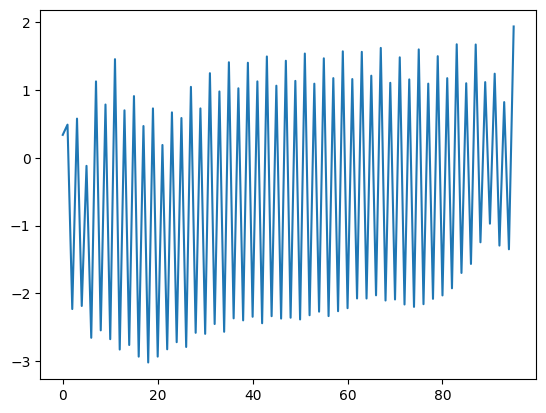

In [12]:
print(mel_sample.shape)
to_plot = mel_sample[0,2,:]
print(to_plot.shape)
print(to_plot)
plt.plot(to_plot)

In [10]:
# Example usage:
audio =  mel_to_audio_griffin_lim(mel_sample, out_wav_path="whisper_recon.wav", is_log=True, log_type="natural", power=1.0, n_iter=120)
sf.write('/home/ahmed348/SSIP/audio_folder/sample.wav', audio, 16000)


Input mel shape: (80, 96)
Inverting mel -> stft using librosa (sr=16000, n_fft=1024, hop_length=160, n_iter=120, power=1.0)
Wrote whisper_recon.wav, duration = 0.950 s, samplerate = 16000
